# Feldman and Cousins intervals with asymptotics.

This is a copy of `FC_interval_freq.ipynb` using the asymptotic formulae instead of toys.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time

import zfit
from zfit.loss import UnbinnedNLL
from zfit.minimize import Minuit
zfit.settings.set_seed(10)

from hepstats.hypotests.calculators import AsymptoticCalculator
from hepstats.hypotests import ConfidenceInterval
from hepstats.hypotests.parameters import POIarray
from hepstats.hypotests.exceptions import POIRangeError

from utils import one_minus_cl_plot, pltdist, plotfitresult

/Users/matthieumarinangeli/anaconda3/envs/tfn2/lib/python3.7/site-packages/zfit/util/execution.py:70: UserWarning: Not running on Linux. Determining available cpus for thread can failand be overestimated. Workaround (only if too many cpus are used):`zfit.run.set_n_cpu(your_cpu_number)`
  warnings.warn("Not running on Linux. Determining available cpus for thread can fail"


In this example we consider an experiment where the observable $x$ is simply the measured value of $\mu$ in an experiment with a Gaussian resolution with known width $\sigma = 1$. We will compute the confidence belt for a 90 % condifdence level for the mean of the Gaussian $\mu$.

We define a sampler below for a Gaussian pdf with $\sigma = 1$ using the `zfit` library, the sampler allows to generate samples for different values of $\mu$. 1000 entries are generated for each sample.

In [2]:
bounds = (-10, 10)
obs = zfit.Space('x', limits=bounds)

mean = zfit.Parameter("mean", 0)
sigma = zfit.Parameter("sigma", 1.0)
model = zfit.pdf.Gauss(obs=obs, mu=mean, sigma=sigma)

data = model.create_sampler(1000)
data.resample()

Below is defined the negative-likelihood function which is needed to compute Feldman and Cousins intervals as described in [arXiv:1109.0714](https://arxiv.org/abs/1109.0714). The negative-likelihood function is mimised to compute the measured mean $x$ and its uncertainty $\sigma_x$.  

In [3]:
# Create the negative log likelihood
nll = UnbinnedNLL(model=model, data=data) 

# Instantiate a minuit minimizer
minimizer = Minuit(verbosity=0)

# minimisation of the loss function
minimum = minimizer.minimize(loss=nll)
minimum.hesse();
print(minimum)

x_err = minimum.params[mean]["minuit_hesse"]["error"]

/Users/matthieumarinangeli/anaconda3/envs/tfn2/lib/python3.7/site-packages/zfit/util/cache.py:283: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return all(np.equal(self.immutable_representation, other.immutable_representation))


FitResult of
<UnbinnedNLL model=[<zfit.Gauss  params=[mean, sigma] dtype=float64>0] data=[<zfit.core.data.Sampler object at 0x7f9d29b75f90>] constraints=[]> 
with
<Minuit strategy=PushbackStrategy tolerance=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 0.00022 │ 1433        │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name        value    minuit_hesse    at limit
------  ---------  --------------  ----------
mean    0.0001496     +/-   0.032       False
sigma       1.014     +/-   0.023       False




To compute the the confidence belt on $\mu$ 90 % CL intervals have to be computed for several values of the measured mean $x$. Samples are generated for $\mu = n \times \sigma_x$ with $n = -6, -5, -4, ..., 3, 4, 5, 6$, and fitted to measure the mean $x_n$. 

90 % CL intervals are evaluated for each $x_n$ for the two following cases, $\mu > 0$ and $\mu$ unbounded.

With `hepstats`, The intervals are obtained with `ConfidenceInterval` object using a calculator. Here the calculator is the `AsymptoticCalculator` which computes the intervals using asymptotic formulae (see [Asymptotic formulae for likelihood-based tests of new physics](https://arxiv.org/pdf/1007.1727.pdf)), an example of a 68 % CL interval with the `AsymptoticCalculator` can be found [here](https://github.com/scikit-hep/hepstats/blob/master/notebooks/hypotests/confidenceinterval_asy_zfit.ipynb).

The option `qtilde = True` should be used if $\mu > 0$.

In [4]:
results = {}

In [5]:
for n in np.arange(-6, 7, 1.0):
        
    x = n * x_err
    
    if n not in results:
        
        zfit.settings.set_seed(5)
    
        data.resample(param_values={mean: x})
    
        minimum = minimizer.minimize(loss=nll)
        minimum.hesse(); 
        
        results_n = {}
        results_n["x"] = minimum.params[mean]["value"]
        results_n["x_err"] = minimum.params[mean]["minuit_hesse"]["error"]
    
        calculator = AsymptoticCalculator(minimum, minimizer)
        
        x_min = results_n["x"] - results_n["x_err"]*3
        x_max = results_n["x"] + results_n["x_err"]*3
        
        if n < -1:
            x_max = max(0.5 * results_n["x_err"], x_max)
        
        poinull = POIarray(mean, np.linspace(x_min, x_max, 50))
      
        results_n["calculator"] = calculator
        results_n["poinull"] = poinull
        
    else:
        results_n = results[n]
        calculator = results_n["calculator"]
        poinull = results_n["poinull"]

    if "mu_lower" not in results_n:
             
        for qtilde in [True, False]:
    
            while True:
                try:
                    ci = ConfidenceInterval(calculator, poinull, qtilde=qtilde)
                    interval = ci.interval(alpha=0.05, printlevel=0)
                    break
                except POIRangeError:
                    values = poinull.values
                    poinull = POIarray(mean, np.concatenate([values, [values[-1] + np.diff(values)[0]]]))
                    results_n["poinull"] = poinull
    
            if qtilde:
                results_n["mu_lower"] = interval["lower"]
                results_n["mu_upper"] = interval["upper"]
            else:
                results_n["mu_lower_unbound"] = interval["lower"]
                results_n["mu_upper_unbound"] = interval["upper"]
    
        results[n] = results_n

/Users/matthieumarinangeli/anaconda3/envs/tfn2/lib/python3.7/site-packages/hepstats/hypotests/core/confidence_interval.py:116: UserWarning: Multiple roots have been founds.
  warnings.warn(msg_warn)


The plot of the confidence belt of $\mu$ at 90 % CL as function of the measured mean values $x$ (in unit of $\sigma_x$), for the bounded and unbounded case are shown below.

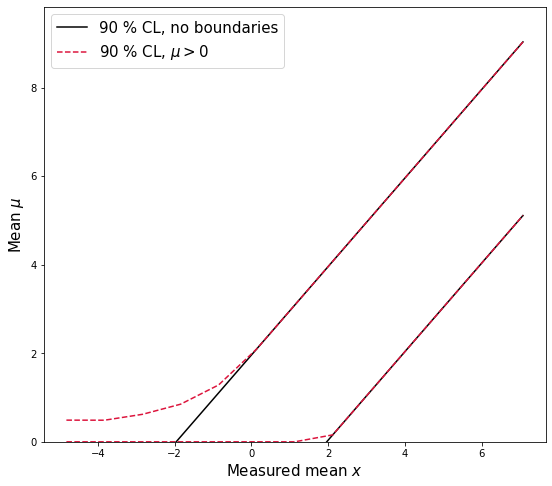

In [6]:
f = plt.figure(figsize=(9, 8))

plt.plot([v["x"]/v["x_err"]  for v in results.values()], 
         [v["mu_upper_unbound"]/v["x_err"]  for v in results.values()], color="black", label="90 % CL, no boundaries")
plt.plot([v["x"]/v["x_err"]  for v in results.values()], 
         [v["mu_lower_unbound"]/v["x_err"]  for v in results.values()], color="black")
plt.plot([v["x"]/v["x_err"]  for v in results.values()], 
         [v["mu_upper"]/v["x_err"]  for v in results.values()], "--", color="crimson", label="90 % CL, $\mu > 0$")
plt.plot([v["x"]/v["x_err"]  for v in results.values()], 
         [v["mu_lower"]/v["x_err"]  for v in results.values()], "--", color="crimson")
plt.ylim(0.)
plt.legend(fontsize=15)
plt.ylabel("Mean $\mu$", fontsize=15)
plt.xlabel("Measured mean $x$", fontsize=15);

For the unbounded and the $\mu > 0$ cases the plot reproduces the figure 3 and 10, respectively, of [A Unified Approach to the Classical Statistical Analysis of Small Signals, Gary J. Feldman, Robert D. Cousins](https://arxiv.org/pdf/physics/9711021.pdf).